In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))  # return the projest's root folder
sys.path.append(project_root)
from utils import bilstm_optmize, load_parameters, data_reshape, create_bilstm_model

2025-01-29 05:44:34.190191: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 05:44:34.227029: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 05:44:34.246917: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 05:44:34.278706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738125874.324076   28662 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738125874.33

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# optuna.logging.set_verbosity(optuna.logging.WARNING)

random_seed = 42
np.random.seed(random_seed)

/root/batteryDT/batteryML/venvSANDIA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load the parameters from file ---------------------------------------------------------
params = load_parameters('parameters.yaml')

dataset: nasa
features: ['voltage', 'current', 'temperature', 'relativeTime']
labels: ['capacity']
data_groupby: ['cycle']
time_window: 40
n_trials: 10


In [4]:
# data read path
folder_path = f'../data/data_{params.dataset}/'

# data save path
data_save_path = f'data_{params.dataset}/'
os.makedirs(os.path.dirname(data_save_path), exist_ok=True)

# model save path
model_save_path = f'model_{params.dataset}/'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

In [5]:
# read the data ----------------------------------------------------------
path_dict = {'train': f'{folder_path}train.csv',
             'valid': f'{folder_path}valid.csv',
             'test': f'{folder_path}test.csv'}
data_dict = {key: pd.read_csv(path) for key, path in path_dict.items()}
data = pd.concat(data_dict, axis=0)

In [6]:
# normalization ----------------------------------------------------------
scaler = MinMaxScaler()
data[params.features] = scaler.fit_transform(data[params.features])

In [7]:
# split tha dataset into train, valid, test ------------------------------
# Identify unique cycles
unique_cycles = data['cycle'].unique()
print("Total unique cycles:", len(unique_cycles))

# Example: 70% train+val, 30% test
trainval_cycles, test_cycles = train_test_split(
    unique_cycles, test_size=0.2, random_state=42
)

# Then within trainval, do 80% train, 20% val
train_cycles, val_cycles = train_test_split(
    trainval_cycles, test_size=0.2, random_state=42
)

train = data[data['cycle'].isin(train_cycles)]
valid = data[data['cycle'].isin(val_cycles)]
test = data[data['cycle'].isin(test_cycles)]

Total unique cycles: 164


In [8]:
# reshape the train and valid data -----------------------------------------------------------------
train_samples, train_targets = data_reshape(train,params.time_window,params.features,params.labels)
valid_samples, valid_targets = data_reshape(valid,params.time_window,params.features,params.labels)

train_samples.shape, valid_samples.shape

((703, 40, 4), (185, 40, 4))

In [9]:
# take the first n rows on each cycle in test data, then rashape ----------------------------------------
test_first_n = pd.DataFrame()
for idx, group in test.groupby(params.data_groupby):
    if params.time_window <= len(group):
        group_head = group[:params.time_window]
        test_first_n = pd.concat([test_first_n, group_head])

test_samples, test_targets = data_reshape(test_first_n,params.time_window,params.features,params.labels)
test_samples.shape

(33, 40, 4)

In [10]:
# get the best parameters ---------------------------------------------------------------------------
study = optuna.create_study(direction='minimize')
study.optimize(
    lambda trial: bilstm_optmize(trial,train_samples,train_targets,valid_samples,valid_targets),
    n_trials=params.n_trials,    # e.g., 10 trials; increase as needed
    n_jobs=-1
) 

best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2025-01-29 05:44:36,409] A new study created in memory with name: no-name-bbaece01-0f41-4c86-96aa-5c31efca32ae
2025-01-29 05:44:36.418502: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


model information -> hidden_size: 14, learning_rate: 0.0053295339730306665
model information -> hidden_size: 14, learning_rate: 0.007806892173632885
model information -> hidden_size: 14, learning_rate: 0.009045252960641393
model information -> hidden_size: 14, learning_rate: 0.0054062757915203305
model information -> hidden_size: 14, learning_rate: 0.006147142032256287
model information -> hidden_size: 14, learning_rate: 0.007625557704980855
model information -> hidden_size: 14, learning_rate: 0.009827391128245572
model information -> hidden_size: 14, learning_rate: 0.00671364367091124


[I 2025-01-29 05:45:12,003] Trial 6 finished with value: 0.004690081812441349 and parameters: {'learning_rate': 0.009827391128245572}. Best is trial 6 with value: 0.004690081812441349.


model information -> hidden_size: 14, learning_rate: 0.00669315161554923


[I 2025-01-29 05:45:13,866] Trial 7 finished with value: 0.004813781939446926 and parameters: {'learning_rate': 0.00671364367091124}. Best is trial 6 with value: 0.004690081812441349.


model information -> hidden_size: 14, learning_rate: 0.005711830547134918


[I 2025-01-29 05:45:16,209] Trial 5 finished with value: 0.004550213925540447 and parameters: {'learning_rate': 0.007625557704980855}. Best is trial 5 with value: 0.004550213925540447.
[I 2025-01-29 05:45:16,571] Trial 0 finished with value: 0.005194704048335552 and parameters: {'learning_rate': 0.0053295339730306665}. Best is trial 5 with value: 0.004550213925540447.
[I 2025-01-29 05:45:17,021] Trial 4 finished with value: 0.0061768172308802605 and parameters: {'learning_rate': 0.006147142032256287}. Best is trial 5 with value: 0.004550213925540447.
[I 2025-01-29 05:45:17,387] Trial 3 finished with value: 0.00564774964004755 and parameters: {'learning_rate': 0.0054062757915203305}. Best is trial 5 with value: 0.004550213925540447.
[I 2025-01-29 05:45:17,536] Trial 2 finished with value: 0.0045790658332407475 and parameters: {'learning_rate': 0.009045252960641393}. Best is trial 5 with value: 0.004550213925540447.
[I 2025-01-29 05:45:18,068] Trial 1 finished with value: 0.0069143190048

Best hyperparameters: {'learning_rate': 0.007625557704980855}


In [11]:
# create BiLSTM model with the best parameters
final_model = create_bilstm_model(    
    # hidden_size=best_params['hidden_size'],
    hidden_size=14,
    learning_rate=best_params['learning_rate']
)

# fit the model ------------------------------------------------------------------------------------------
final_model.fit(
    train_samples,
    train_targets,
    epochs=100,
    batch_size=32,
    validation_data=(valid_samples, valid_targets),
    verbose=0
)

# Evaluate on test set -----------------------------------------------------------------------------------
test_loss, test_mae = final_model.evaluate(test_samples, test_targets, verbose=0)
print(f"Final model - Test Loss: {test_loss}, Test MAE: {test_mae}")

model information -> hidden_size: 14, learning_rate: 0.007625557704980855
Final model - Test Loss: 0.009343293495476246, Test MAE: 0.08706462383270264


In [12]:
# Save the final best model -----------------------------------------------------------------
final_model.save(f"{model_save_path}nasa_len{params.time_window}_{str(f"{test_mae:.4f}".split(".")[1])}.keras")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


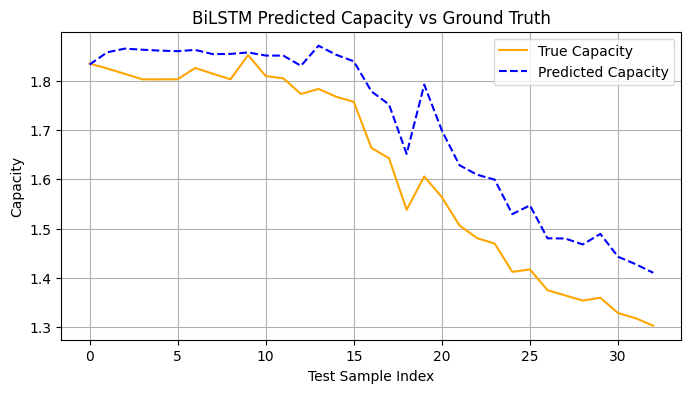

In [13]:
y_pred = final_model.predict(test_samples).flatten()

plt.figure(figsize=(8,4))
plt.plot(test_targets, label='True Capacity', color='orange')
plt.plot(y_pred, label='Predicted Capacity', color='blue', linestyle='--')
plt.title('BiLSTM Predicted Capacity vs Ground Truth')
plt.xlabel('Test Sample Index')
plt.ylabel('Capacity')
plt.legend()
plt.grid()
plt.show()

In [14]:
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 28)             │         2,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,473 (25.29 KB)

 Trainable params: 2,157 (8.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,316 (16.86 KB)